# Temperature and salinity biases at selected depth levels

The goal of this notebook is the following:

1) serve as an example of how to post-process CESM/MOM6 output;

2) create time averages of T/S fields at depth levels and compared agains observations (WOA18);

Temprature and salinity comparisons (model vs obs) at selected depth levels are grouped into the following regions: Global, Antarctic, and Arctic.

In [1]:
%matplotlib inline
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6plot import xycompare, polarcomparison
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools import m6toolbox
import yaml, os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import display, Markdown, Latex
import warnings
warnings.filterwarnings("ignore")

/glade/work/gmarques/miniconda/envs/dev2/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
# Empty cell with "parameters" tag, papermill-provided parameters will be inserted below.

## Connecting to cluster

In [4]:
from dask.distributed import Client

if cluster_scheduler_address is None:
    pass
else:
    client = Client(cluster_scheduler_address)
    
    client

In [2]:
dcase = DiagsCase(diag_config_yml['Case'])
print('Casename is:', dcase.casename)

Casename is: gmom.e23.GJRAv4.TL319_t061_zstar_N65.nuopc.HBD.002


### This is the only cell that needs to be modified

In [3]:
file_stream = '.mom6.h_000?_??.nc'
start_date = diag_config_yml['Avg']['start_date']
end_date = diag_config_yml['Avg']['end_date']
output_path = dcase.get_value('RUNDIR') 
# load WOA18 data
obs_temp = xr.open_dataset(WOA18_temp_path,
                              decode_times=False).rename({'theta0': 'TEMP', 'z_l' : 'depth'});
obs_salt = xr.open_dataset(WOA18_salt_path,
                              decode_times=False).rename({'s_an': 'SALT', 'z_l' : 'depth'});

if not os.path.isdir('../ncfiles'):
    os.system('mkdir ../ncfiles');

save_path = os.path.abspath('../ncfiles')

In [4]:
# read grid info
grd = MOM6grid(output_path+'/'+dcase.casename+'.mom6.static.nc');
grd_xr = MOM6grid(output_path+'/'+dcase.casename+'.mom6.static.nc', xrformat=True);

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 



In [5]:
cluster = NCARCluster()
cluster.scale(6)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/highmem/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/highmem/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.26:38397,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/highmem/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [13]:
# Compute the climatology dataset
#dset_climo = climo.stage()
variables = ['thetao', 'so', 'time', 'time_bnds']

def preprocess(ds):
    ''' Compute montly averages and return the dataset with variables'''
    return ds[variables]#.resample(time="1Y", closed='left', \
           #keep_attrs=True).mean(dim='time', keep_attrs=True)

ds = xr.open_mfdataset(output_path+'/'+dcase.casename+file_stream, \
         parallel=True, data_vars='minimal', \
         coords='minimal', compat='override', preprocess=preprocess)

In [10]:
def weighted_temporal_mean(ds, var):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [15]:
ds_theta_tmp = weighted_temporal_mean(ds, 'thetao')

In [16]:
ds_theta_tmp

<xarray.DataArray (time: 9, z_l: 34, yh: 458, xh: 540)>
dask.array<truediv, shape=(9, 34, 458, 540), dtype=float64, chunksize=(1, 34, 458, 540), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -79.2 -79.08 -78.95 -78.82 ... 87.55 87.64 87.71 87.74
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 4.5e+03 5e+03 5.5e+03 6e+03
  * xh       (xh) float64 -286.7 -286.0 -285.3 -284.7 ... 70.67 71.33 72.0 72.67
  * time     (time) object 0001-01-01 00:00:00 ... 0009-01-01 00:00:00

In [17]:
print('Time averaging...')
%time
temp = np.ma.masked_invalid((weighted_temporal_mean(ds, 'thetao')).mean('time').values)
salt = np.ma.masked_invalid((weighted_temporal_mean(ds, 'so')).mean('time').values)

Time averaging...
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


### Save netCDF files

In [18]:
attrs = {'description': 'model - obs at depth levels',
       'start_date': start_date,
       'end_date': end_date,
       'casename': dcase.casename,
       'obs': woa_path}

# create dataset to store results
thetao = xr.DataArray(temp, dims=['z_l','yh','xh'],
          coords={'z_l' : ds.z_l, 'yh' : grd.yh, 'xh' : grd.xh}).rename('thetao')
temp_bias = np.ma.masked_invalid(temp - obs_temp['TEMP'].values)
ds_thetao = xr.Dataset(data_vars={ 'thetao' : (('z_l','yh','xh'), thetao.values),
                        'thetao_bias' :     (('z_l','yh','xh'), temp_bias)},
                        coords={'z_l' : ds.z_l, 'yh' : grd.yh, 'xh' : grd.xh})
m6toolbox.add_global_attrs(ds_thetao,attrs)

ds_thetao.to_netcdf(save_path + '/'+str(dcase.casename)+'_thetao_time_mean.nc')
so = xr.DataArray(ds.so.mean('time'), dims=['z_l','yh','xh'],
          coords={'z_l' : ds.z_l, 'yh' : grd.yh, 'xh' : grd.xh}).rename('so')
salt_bias = np.ma.masked_invalid(so.values - obs_salt['SALT'].values)
ds_so = xr.Dataset(data_vars={ 'so' : (('z_l','yh','xh'), so.values),
                        'so_bias' :     (('z_l','yh','xh'), salt_bias)},
                        coords={'z_l' : ds.z_l, 'yh' : grd.yh, 'xh' : grd.xh})
m6toolbox.add_global_attrs(ds_so,attrs)
ds_so.to_netcdf(save_path + '/'+str(dcase.casename)+'_so_time_mean.nc')

In [19]:
# client.close(); cluster.close()

### Potential temperature
#### Global

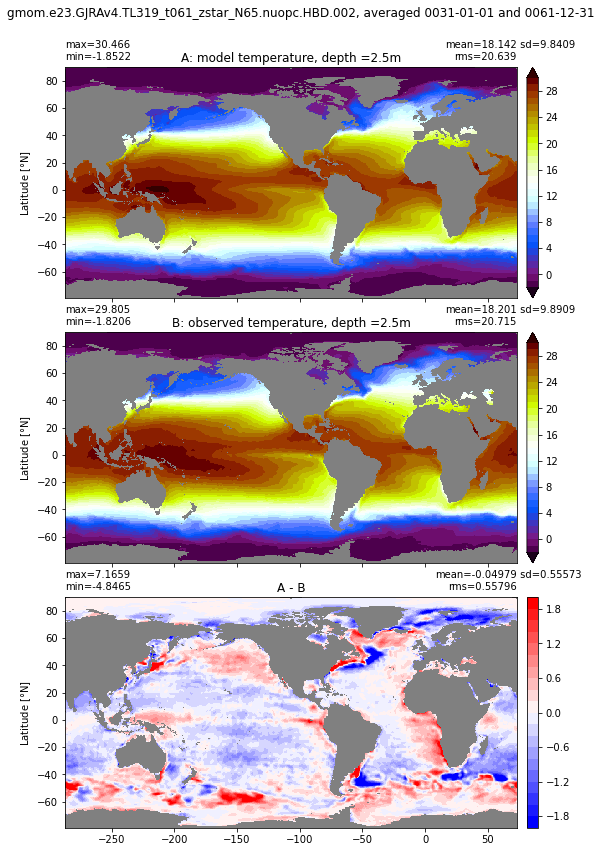

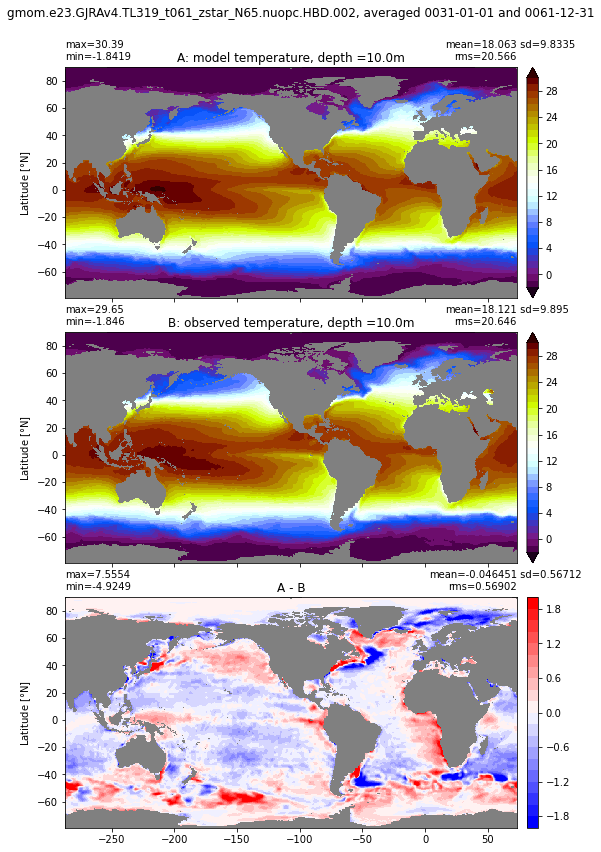

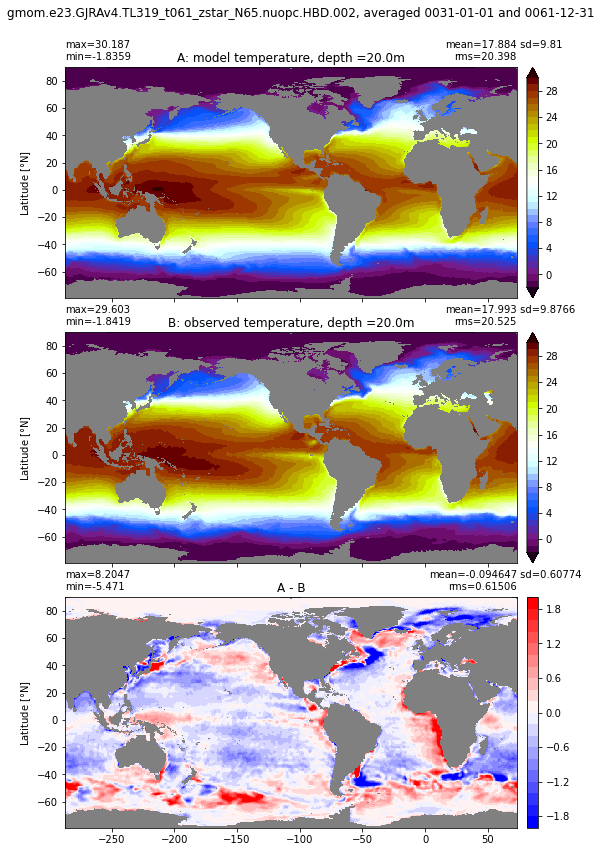

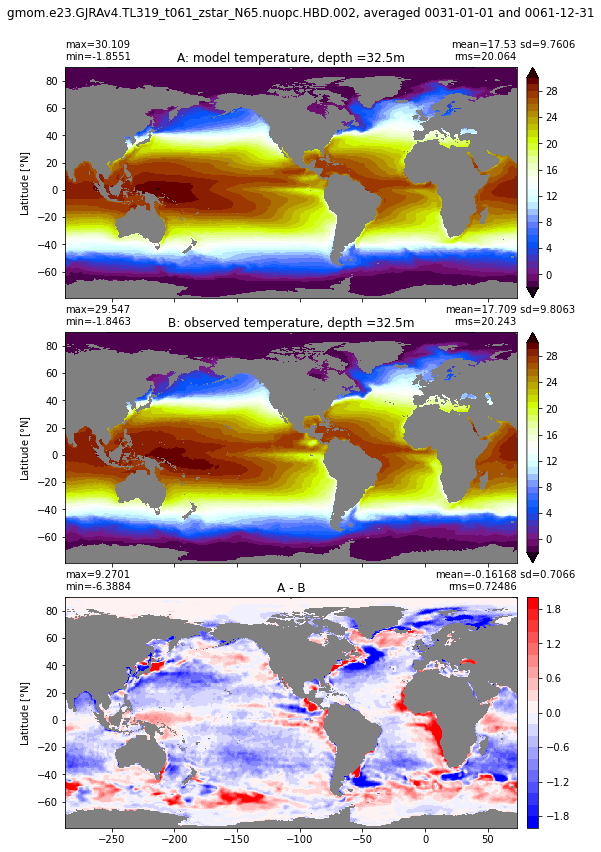

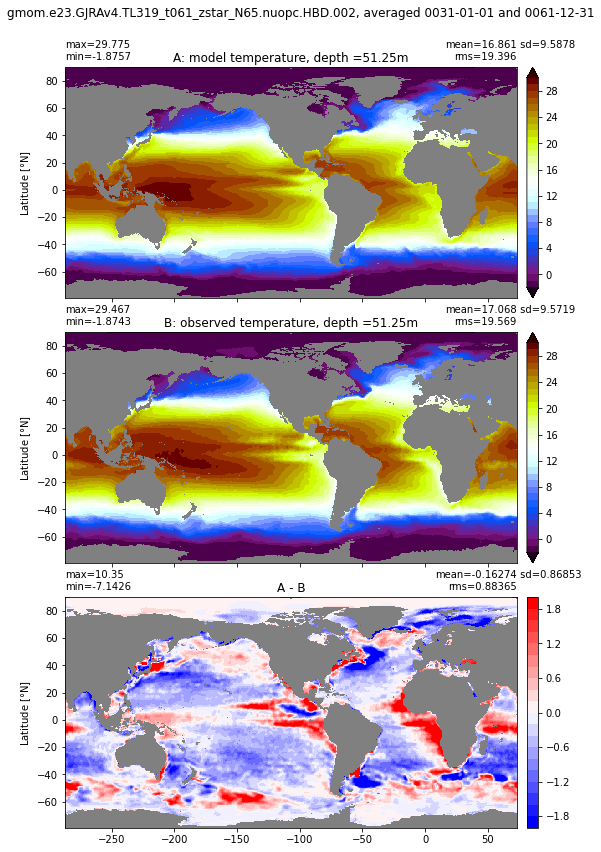

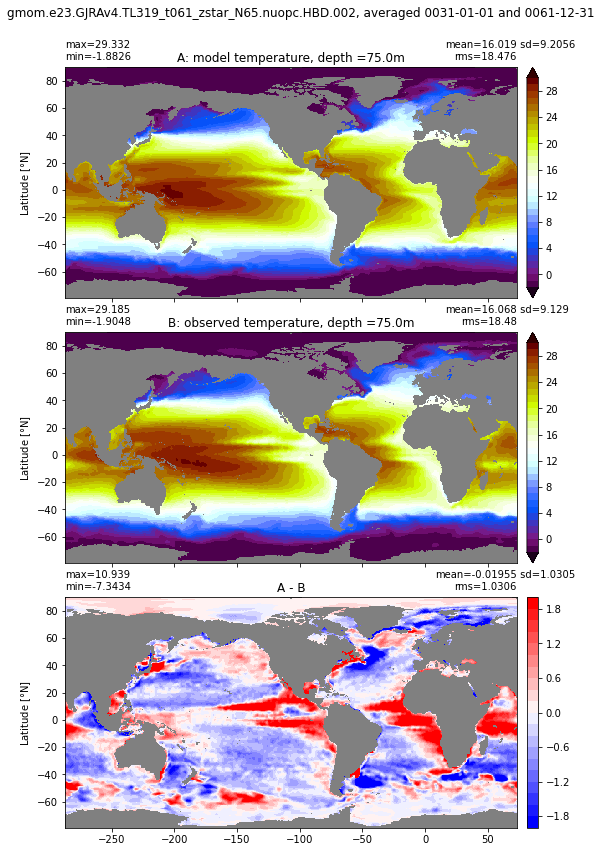

In [20]:
%matplotlib inline
km = len(obs_temp['depth'])
for k in range(km):
  if ds['z_l'][k].values < 100.0:
    temp_obs = np.ma.masked_invalid(obs_temp['TEMP'][k,:].values)
    xycompare(temp[k,:] , temp_obs, grd.geolon, grd.geolat, area=grd.area_t,
            title1 = 'model temperature, depth ='+str(ds['z_l'][k].values)+ 'm',
            title2 = 'observed temperature, depth ='+str(obs_temp['depth'][k].values)+ 'm',
            suptitle=dcase.casename + ', averaged '+str(start_date)+ ' and ' +str(end_date),
            clim=(-1.9,30.), dcolormap=plt.cm.bwr,
            extend='both', dextend='neither', dlim=(-2,2),
            show= True)

### Salinity
#### Global

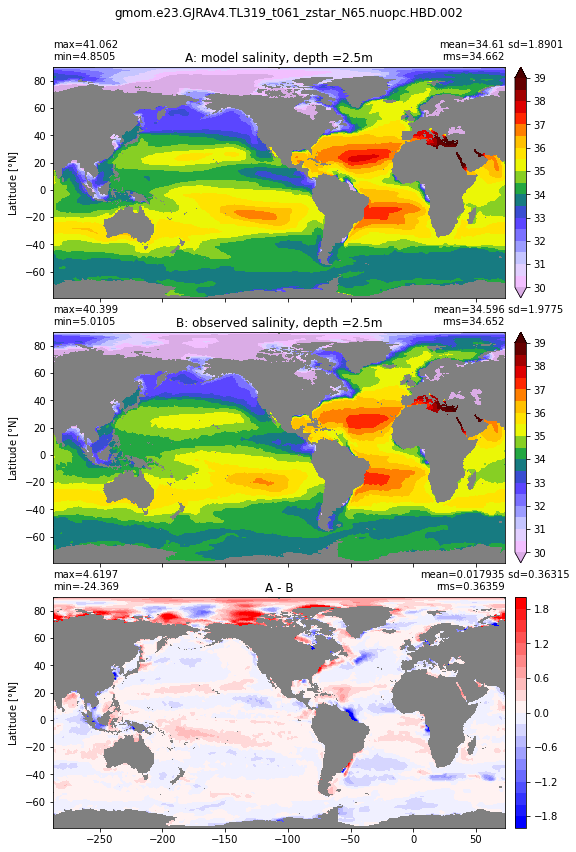

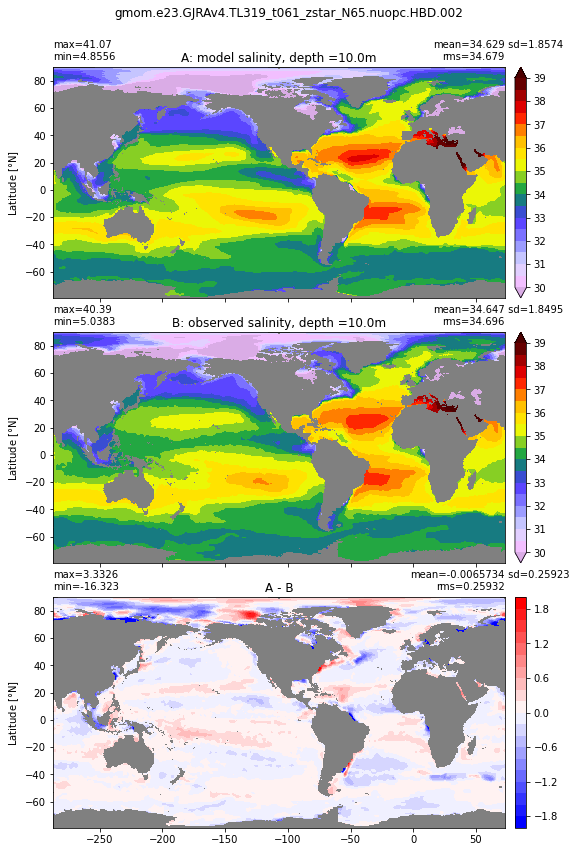

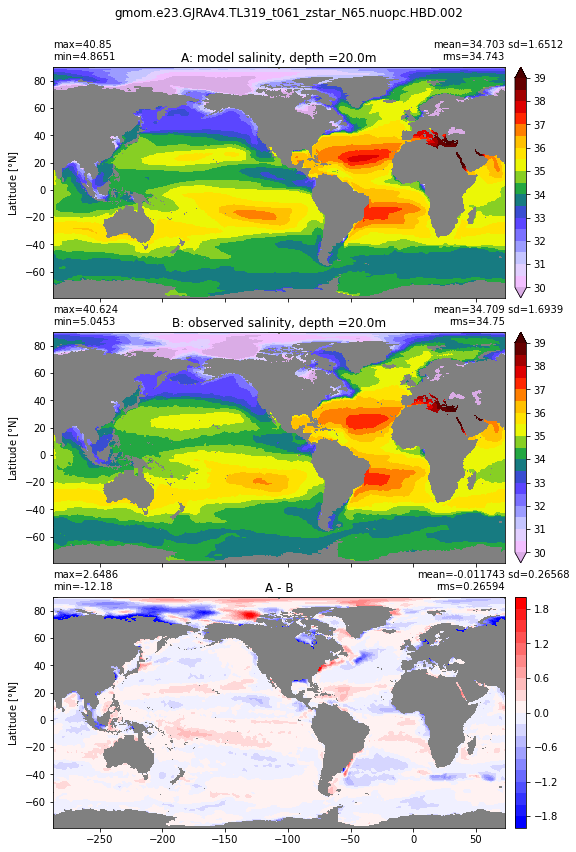

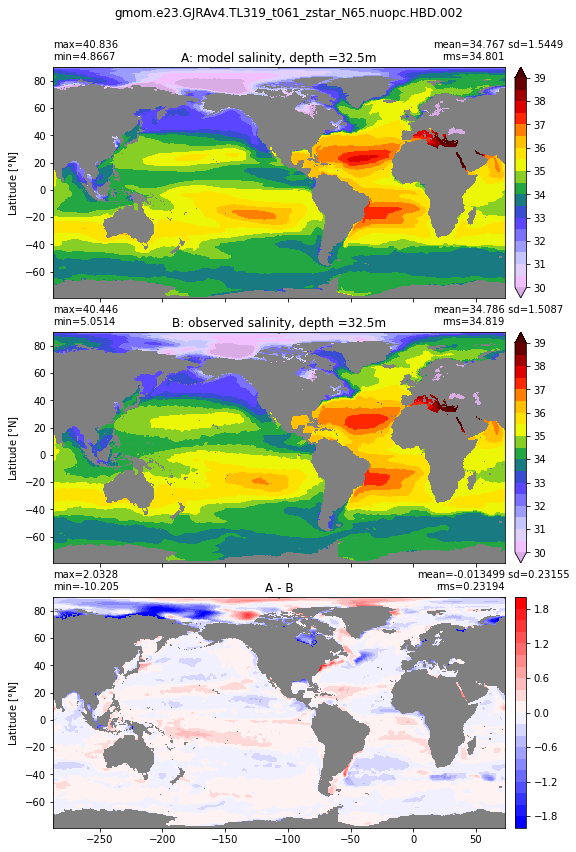

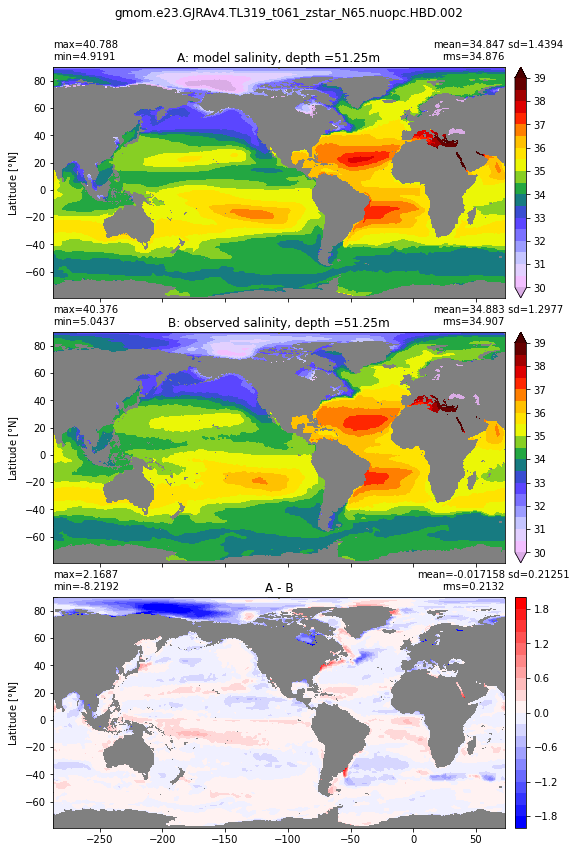

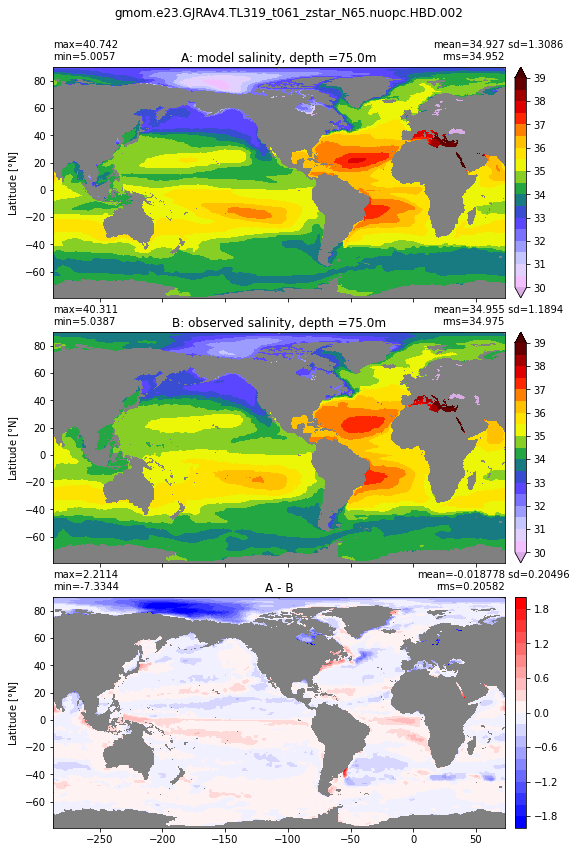

In [23]:
%matplotlib inline
km = len(obs_temp['depth'])
for k in range(km):
  if ds['z_l'][k].values < 100.0:
    salt_obs = np.ma.masked_invalid(obs_salt['SALT'][k,:].values)
    xycompare( salt[k,:] , salt_obs, grd.geolon, grd.geolat, area=grd.area_t,
            title1 = 'model salinity, depth ='+str(ds['z_l'][k].values)+ 'm',
            title2 = 'observed salinity, depth ='+str(obs_temp['depth'][k].values)+ 'm',
            suptitle=dcase.casename, clim=(30,39.), dcolormap=plt.cm.bwr,
            extend='both', dextend='neither', dlim=(-2,2),
            show= True)